In [1]:
# As usual, a bit of setup
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from nnet.data.data_utils import get_CIFAR10_data
from nnet.data.data_augmentation import *
from nnet.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from nnet.solver import Solver
from nnet.data.data_utils import load_CIFAR10
from res_net import ResNet

from nnet.utils.vis_utils import visualize_grid
import matplotlib

%matplotlib inline
#matplotlib.style.use('ggplot')


plt.rcParams['figure.figsize'] = (12.0, 7) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-2, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data('nnet/data/cifar-10-batches-py',
    num_training=50000, num_validation=0, num_test=10000)

classes = [ 'airplane',
            'automobile' ,
            'bird' ,
            'cat' ,
            'deer' ,
            'dog' ,
            'frog' ,
            'horse' ,
            'ship', 
            'truck']

for k, v in data.iteritems():
  print '%s: ' % k, v.shape


std:  ()
X_val:  (0, 3, 32, 32)
X_train:  (50000, 3, 32, 32)
y_train:  (50000,)
X_test:  (10000, 3, 32, 32)
y_val:  (0,)
y_test:  (10000,)
mean:  (3, 32, 32)


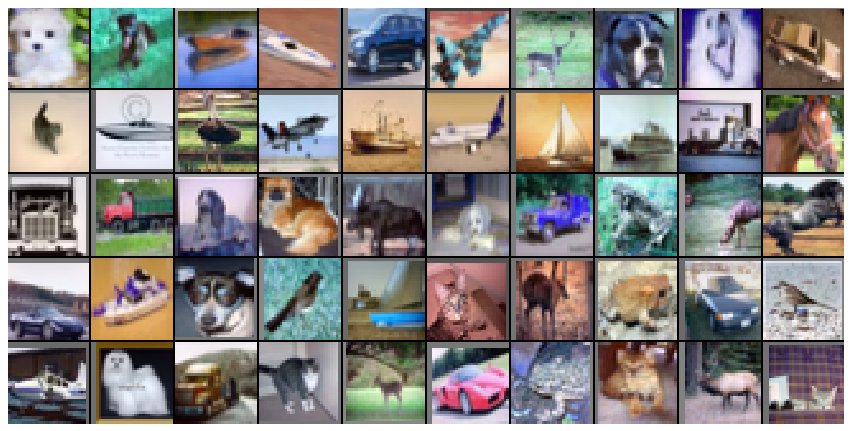

In [6]:


def data_augm(batch):
    p = 4
    h, w = 32, 32

    #batch = random_tint(batch)
    #batch = random_contrast(batch)
    batch = random_flips(batch)
    #batch = random_rotate(batch, 10)
    batch = random_crops(batch, (h, w), pad=2)
    return batch
N = data['X_train'].shape[0]
d = data['X_train'][np.random.randint(N,size=50)]


grid = visualize_grid(data_augm(d).transpose(0, 2, 3, 1), grid_size=(10,5))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(grid.astype('uint8'))

#plt.savefig('mini_resnet_overfitting_images.png', dpi=100)


#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
#plt.imshow(grid.astype('uint8'))

In [141]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

matplotlib.rcParams.update({'font.size': 13})


def show_all(loss, tr_err, val_err, ylim1=None, ylim2=None):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    print '## Total training loss and train/ val errors'
    ax = plt.subplot(gs1[0])#2, 1, 1)
    
    
    ax1 = plt.plot(loss)
    plt.setp(ax1, color='#ff4040')
    if ylim1: ax.set_ylim(ylim1)
    plt.ylabel('costo')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    plt.xlabel('iterazione')

    ax = plt.subplot(gs1[1])#2, 1, 2)
    ax1 = plt.plot(tr_err)
    plt.setp(ax1, color='#ff4040')

    ax1 = plt.plot(val_err)
    
    plt.setp(ax1, color='#104E8B')
    
    if ylim2: ax.set_ylim(ylim2)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.legend(['train', 'val'], loc='lower left')
    gs1.tight_layout(fig)
    
def show_loss(loss, ylim=None):
    print '## Loss'
    ts = pd.DataFrame(loss, columns=['loss'])
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('costo')
    plt.xlabel('iterazione')
    
def show_train_val(tr_err, val_err, ylim=None):
    print '## Training and Validation error'
    ts = pd.DataFrame(zip(tr_err, val_err), columns=['train', 'val'])
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    
def show_weights(exp):
    print '## Weights visualization'
    plt.grid(True, color='w', linestyle='-', linewidth=0)
    w = np.load('../Experiments/%d/model.npy' % exp).item()['W1']

    grid = visualize_grid(w.transpose(0, 2, 3, 1))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    plt.imshow(grid.astype('uint8'))
    
    
def show_err_comp(errs, names, losses=None, ylim=None):
    print '## Error Comparision'
    #ts = pd.DataFrame(zip(*errs), columns=names)


    ax = plt.plot(errs[0])
    #ax = ts.plot(style=['-', '--', '-', '--'])
    plt.setp(ax, color='#104E8B', ls='-')
    ax = plt.plot(errs[1])
    plt.setp(ax, color='#104E8B', ls='--')
    ax = plt.plot(errs[2])
    plt.setp(ax, color='#ff4040',ls='-')
    ax = plt.plot(errs[3])
    plt.setp(ax, color='#ff4040',ls='--')
    plt.legend(names, loc='upper right')


    if ylim: ax.set_ylim(ylim)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.show()

        
def show_loss_comp(losses, names, ylim=None):
    print '## Loss'
    ts = pd.DataFrame(zip(*losses), columns=names)
    ax = ts.plot()
    if ylim: ax.set_ylim(ylim)
    plt.ylabel('costo')
    plt.xlabel('iterazione')
    plt.show()
    
    
def show_all_comp(losses, loss_names, errs, err_names,  ylim1=False, ylim2=False):
    fig = plt.figure()
    gs1 = gridspec.GridSpec(2, 1)
    print '## Total training loss and train/ val errors'
    ax = plt.subplot(gs1[0])#2, 1, 1)
    
    ax1 = plt.plot(losses[1])
    plt.setp(ax1, color='#104E8B')
    ax1 = plt.plot(losses[0])
    plt.setp(ax1, color='#ff4040')
    plt.legend(loss_names, loc='upper right')
    if ylim1: ax.set_ylim(ylim1)
    plt.ylabel('costo')
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    plt.xlabel('iterazione')
    
    ax1 = plt.subplot(gs1[1])#2, 1, 2)
    
    ax = plt.plot(errs[0])
    #ax = ts.plot(style=['-', '--', '-', '--'])
    plt.setp(ax, color='#104E8B', ls='-')
    ax = plt.plot(errs[1])
    plt.setp(ax, color='#104E8B', ls='--')
    ax = plt.plot(errs[2])
    plt.setp(ax, color='#ff4040',ls='-')
    ax = plt.plot(errs[3])
    plt.setp(ax, color='#ff4040',ls='--')
   # plt.legend(err_names, loc='upper right')


    if ylim2: ax1.set_ylim(ylim2)
    plt.ylabel('errore')
    plt.xlabel('epoca')
    plt.show()
    
    
    
    
    
def results_for_exp(exp):
    loss = moving_average(np.load('../Experiments/%s/loss.npy' % exp))
    tr_acc = np.loadtxt('../Experiments/%s/train_acc_history.csv' % exp, delimiter=',')[:,-1]
    val_acc = np.loadtxt('../Experiments/%s/val_acc_history.csv' % exp, delimiter=',')[:,-1]
    tr_err = 1 - tr_acc
    val_err = 1 - val_acc
    return loss, tr_err, val_err
    

---
# Exp.0: nSize = 3 Check Overfitting Capability

Model:

        Residual Network:
            NSize: 3;
            Numbers of filters for each layer:[16, 16, 16, 16, 16, 16, 16, 32, 32, 32, 32, 32, 32, 64, 64, 64, 64, 64, 64];
            Optional linear layers dimensions: [];
            Regularization factor: 0.000000;

Solver:

        Number of processes: 1;
        Update Rule: sgd_th;
        Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0, 'momentum': 0.9};
        Learning Rate Decay: 1;
        Batch Size: 50;
        Number of Epochs: 50;

Data Augmentation Function:

	def data_augm(batch):
	    p = 4
	    h, w = XH, XW
	    #batch = random_tint(batch)
	    #batch = random_contrast(batch)
	    #batch = random_flips(batch)
	    #batch = random_rotate(batch, 10)
	    #batch = random_crops(batch, (h, w), pad=p)
	    return batch

Custom Weight Decay Update Rule:

	def custom_update_decay(epoch):
	    if epoch in (80, 160):
	        return 0.1
	    return 1

Training for 50 epochs (250 iterations).


## Total training loss and train/ val errors

## Total training loss and train/ val errors


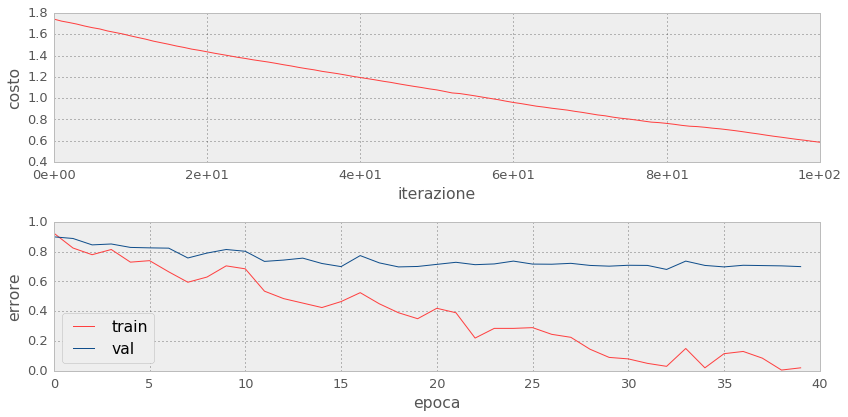

In [29]:
loss, tr_err, val_err = results_for_exp(10)
show_all(loss, tr_err, val_err)

## Weights visualization


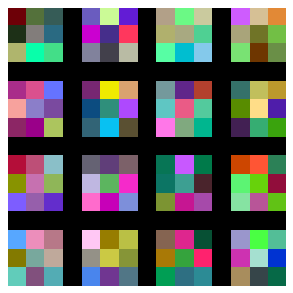

In [43]:
show_weights(10)

---
# Exp.0: nsize 1 w/ and w/o skip path

## nSize = 1

Update Rule: sgd_th;
- Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9};
- Learning Rate Decay: 1;
- Batch Size: 50;
- Number of Epochs: 160; 160000 iterations (1000 it/epoch)
- Print every: 100


## Total training loss and train/ val errors


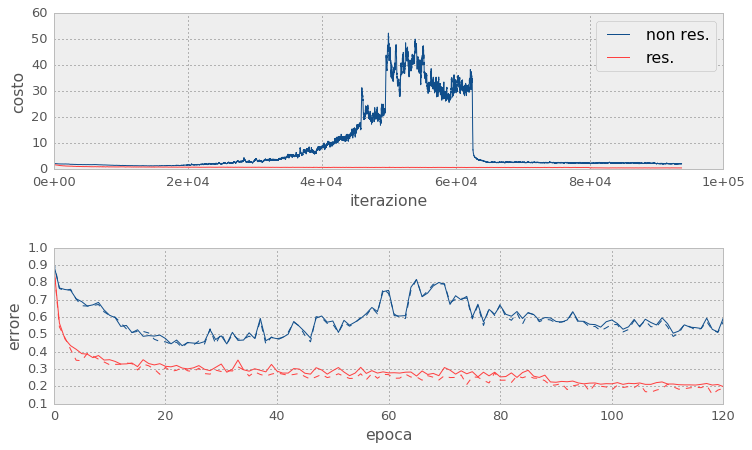

In [77]:

loss2, tr_err1, val_err1 = results_for_exp(15)
loss1, tr_err2, val_err2 = results_for_exp(1)


#show_loss_comp((loss1, loss2), ['non residual', 'residual'])

losses = (loss1[:len(loss2)], loss2)
losses_names = ('non res.', 'res.')
errs = (val_err1, tr_err1, val_err2[:121], tr_err2[:121])
err_names = ('non res (val)', 'non res (train)',  'res (val)', 'res (train)')
show_all_comp(losses , losses_names, errs, err_names)

---
# Exp.1: nsize 1, pad=2/4

## nSize = 1, nPad = 2

Update Rule: sgd_th;
- Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9};
- Learning Rate Decay: 1;
- Batch Size: 50;
- Number of Epochs: 160; 160000 iterations (1000 it/epoch)
- Print every: 100


## Total training loss and train/ val errors

## Total training loss and train/ val errors


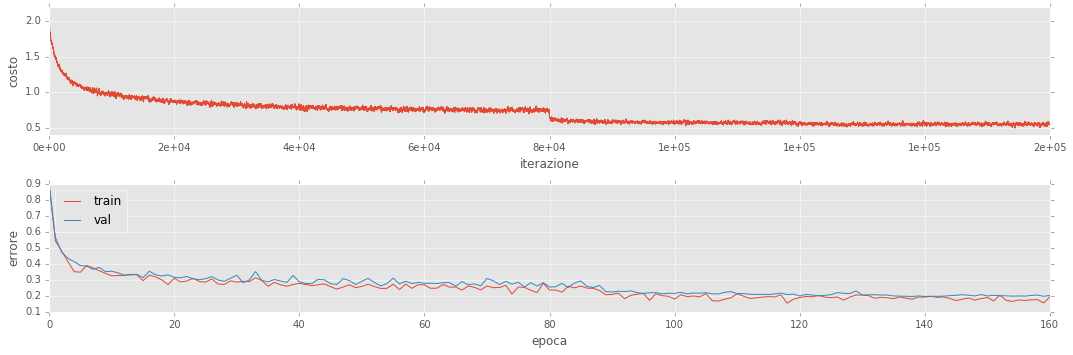

In [63]:
loss, tr_err, val_err = results_for_exp(1)
show_all(loss, tr_err, val_err)

## Training and Validation error


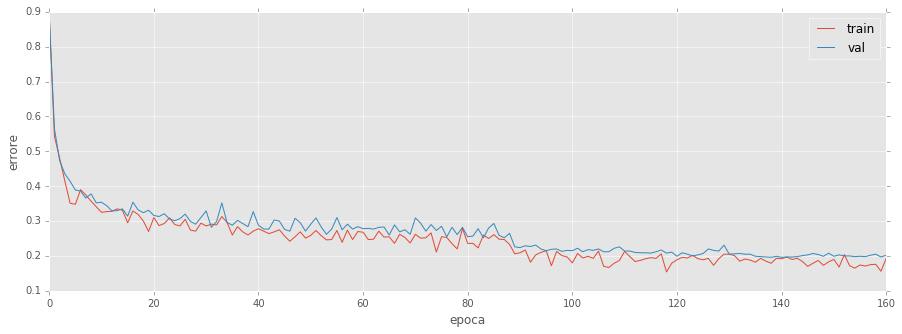

In [64]:
show_train_val(tr_err, val_err)

## Training and Validation error


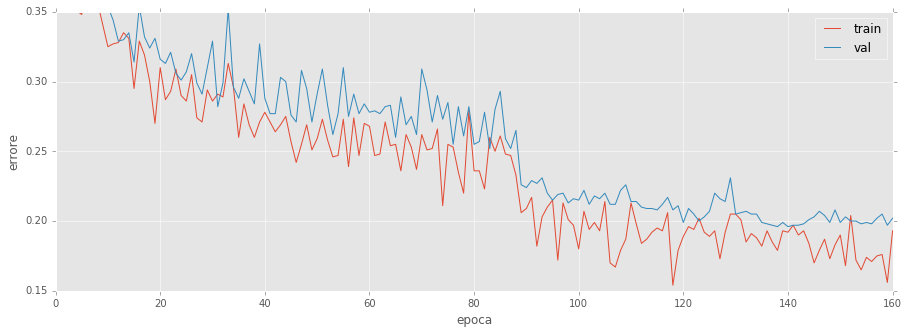

In [65]:
show_train_val(tr_err, val_err, ylim=(0.15, 0.35))

## Weights visualization


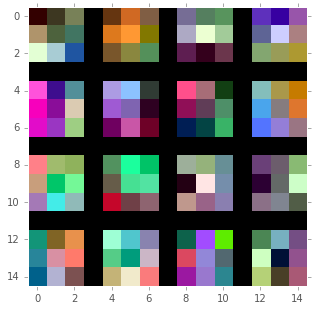

In [103]:
show_weights(1)

---
## nSize = 1, nPad = 4

Update Rule: sgd_th;
- Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9};
- Learning Rate Decay: 1;
- Batch Size: 50;
- Number of Epochs: 160; 160000 iterations (1000 it/epoch)
- Print every: 100

## Total training loss and train/ val errors

In [42]:
loss, tr_err, val_err = results_for_exp(2)

## Total training loss and train/ val errors


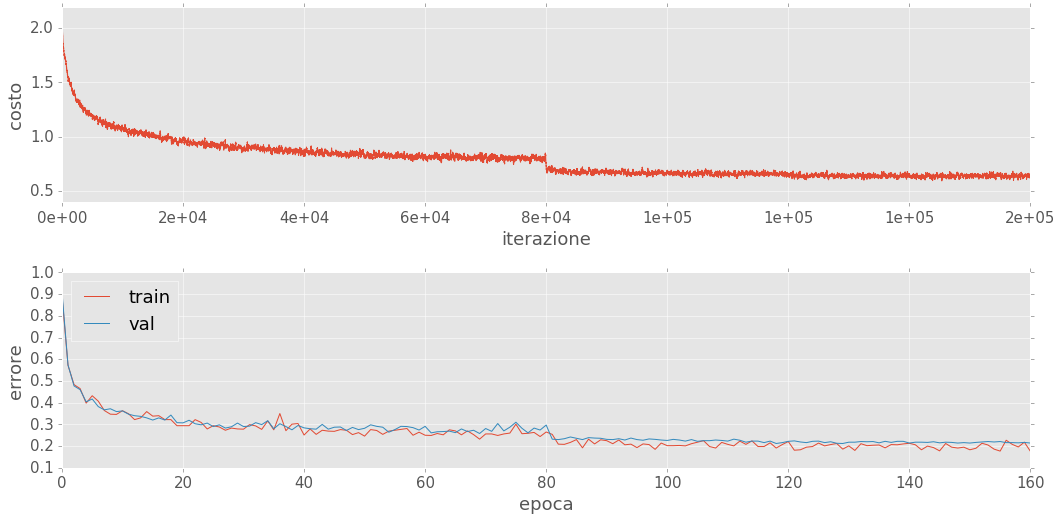

In [43]:
show_all(loss, tr_err, val_err)

Loss is more noisly because the sample data is a bit more ambigous 

## Training and Validation error

## Training and Validation error


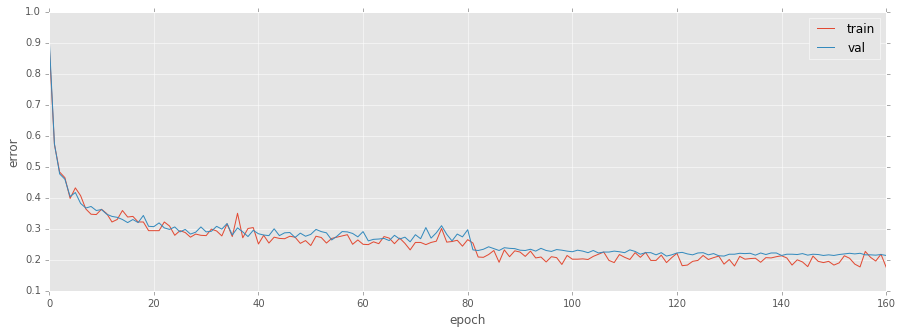

In [195]:
show_train_val(tr_err, val_err)

## Zoomed Training and Validation Error

## Training and Validation error


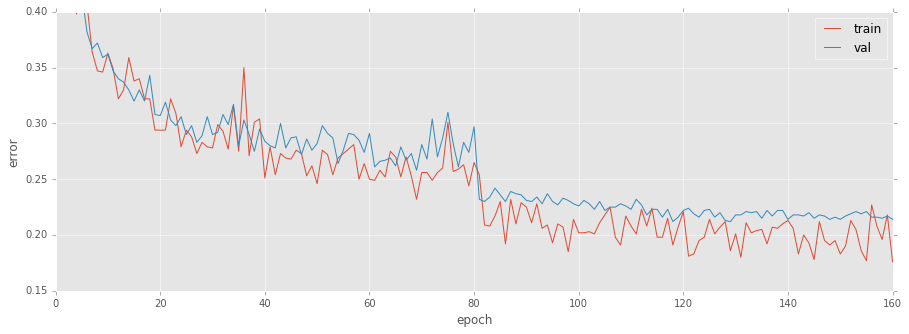

In [197]:
show_train_val(tr_err, val_err, ylim=(0.15, 0.4))

## First Layer's Weights visualization

## Weights visualization


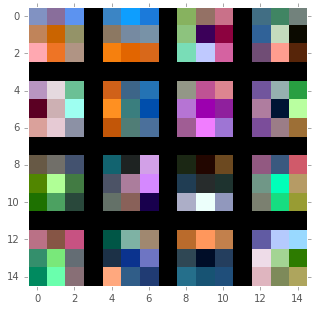

In [113]:
show_weights(2)

First layers filters look more robusts

---
# Exp.1 Results

In [214]:
loss1, tr_err1, val_err1 = results_for_exp(1)
loss2, tr_err2, val_err2 = results_for_exp(2)



## Loss

## Loss


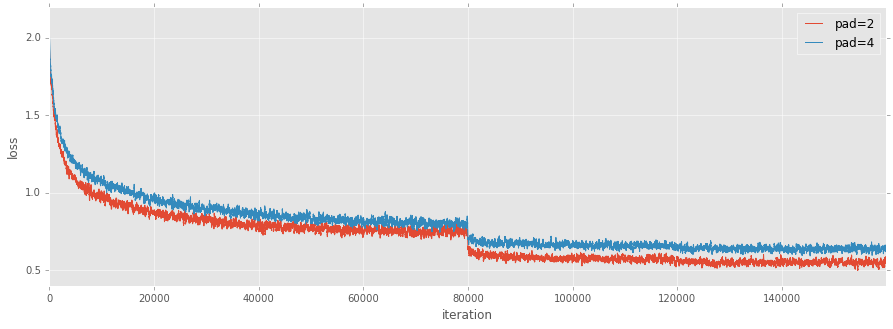

In [218]:
show_loss_comp((loss1, loss2), ['pad=2', 'pad=4'])


## Validation Error

## Error Comparision


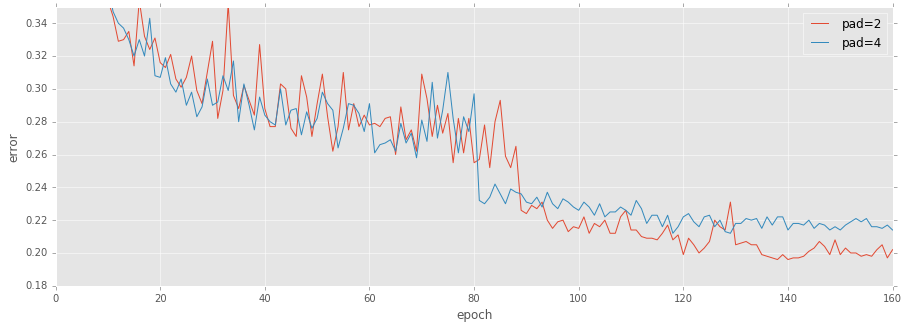

In [221]:
loss1, tr_err1, val_err1 = results_for_exp(1)
loss2, tr_err2, val_err2 = results_for_exp(2)
show_err_comp((val_err1, val_err2), ['pad=2', 'pad=4'], ylim=(0.18, 0.35))

So: it seems that on a "not very deep network", when learning rate = .1 (before epoch 80), they perform in a very similiar way, altough using pad=2 gives more noisly error. 
After epch 80, learning rate becomes .01 (fine tuning), it seems that using a padding of 2 pixels is more convenient than using a pad of 4 pixels.

---
# Exp.2: nSize 3, pad=2/4

## nSize = 3, nPad = 2
#### Final accuracy: 0.904

Update Rule: sgd_th;
- Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9};
- Batch Size: 64;
- Number of Epochs: 160;


## Total training loss and train/ val errors


## Total training loss and train/ val errors


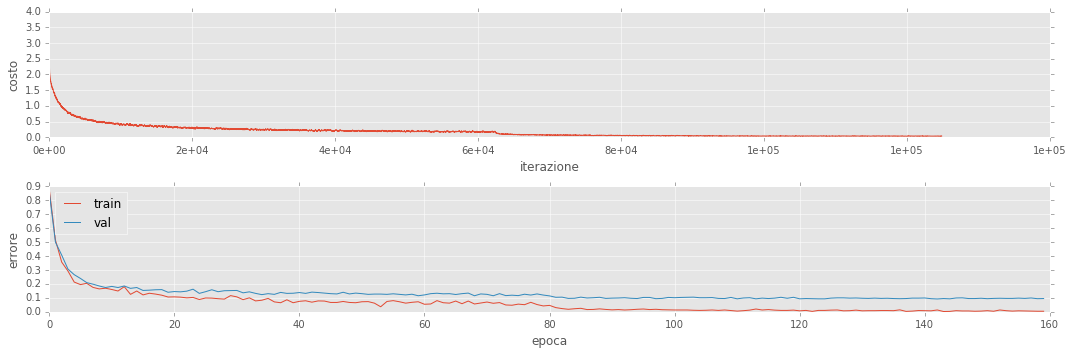

In [66]:
loss, tr_err, val_err = results_for_exp(3)
show_all(loss, tr_err, val_err)

## Loss


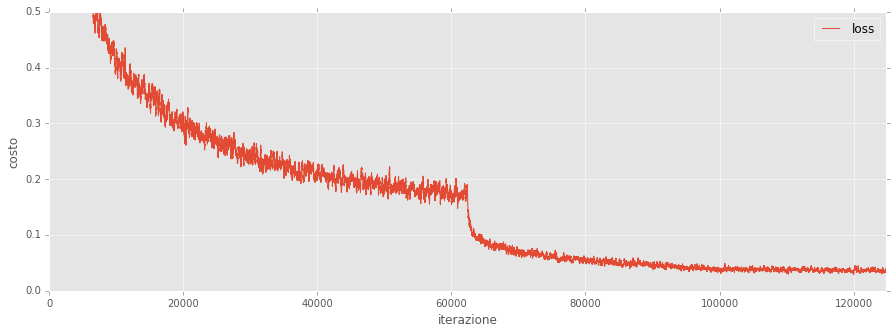

In [67]:
show_loss(loss, ylim=(.0, .5))

## Training and Validation error

## Training and Validation error


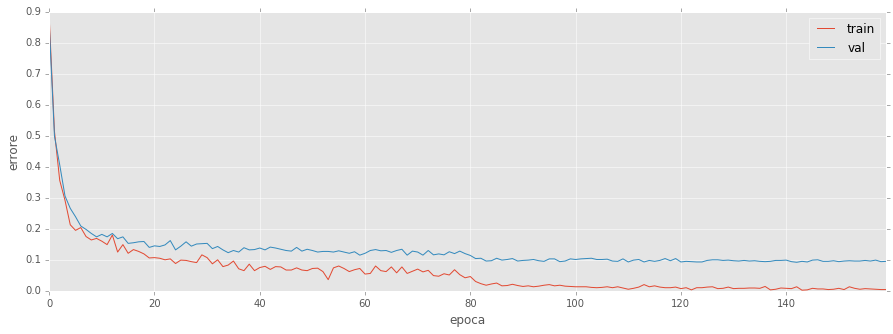

In [68]:
show_train_val(tr_err, val_err)

errors are a lot less noisly in respect when nSize = 1

## Zoomed Training and Validation Error


## Training and Validation error


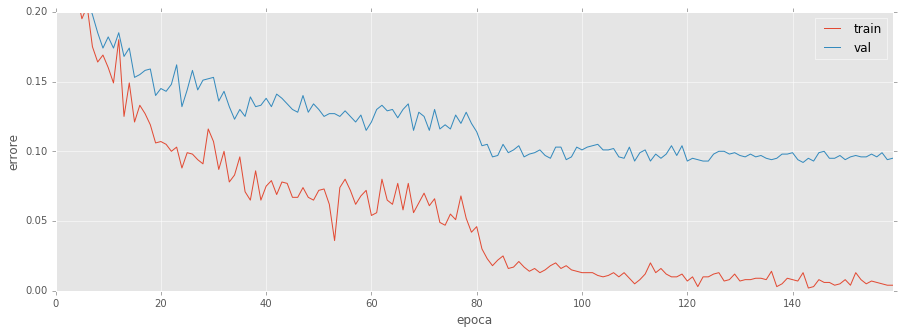

In [69]:
show_train_val(tr_err, val_err, (0.0, 0.2))

Now overfitting is more evident than before. After ~120 epochs the network recognize ~99.9% of the training samples.

## First Layer's Weights visualization

## Weights visualization


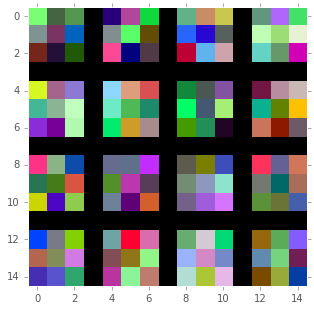

In [211]:
show_weights(2)

---
## nSize = 3, nPad = 4

Update Rule: sgd_th;
- Optim Config: {'nesterov': True, 'learning_rate': 0.1, 'weight_decay': 0.0001, 'momentum': 0.9};
- Batch Size: 128;
- Number of Epochs: 160;


## Total training loss and train/ val errors


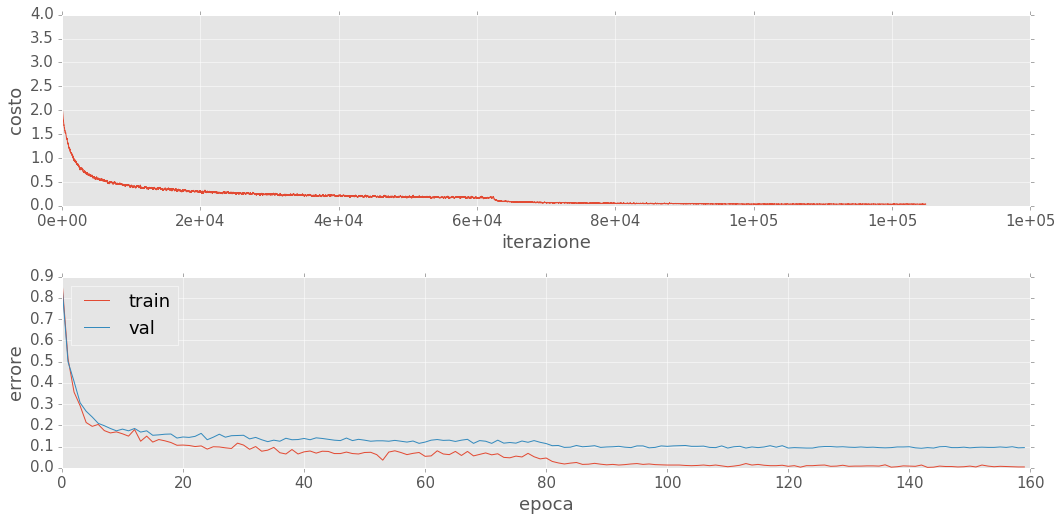

In [30]:
loss3, tr_err3, val_err3 = results_for_exp(3)
show_all(loss3, tr_err3, val_err3)

## Total training loss and train/ val errors


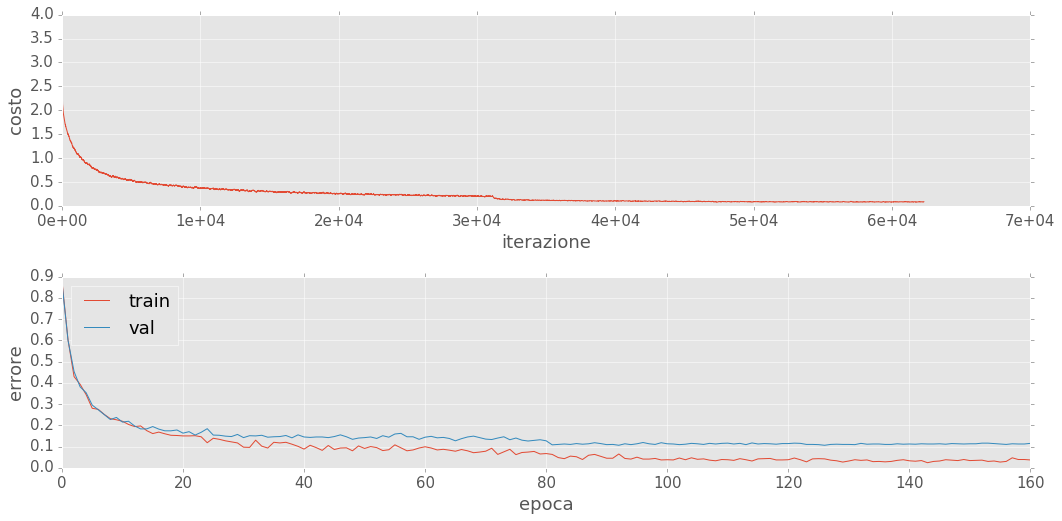

In [31]:
loss4, tr_err4, val_err4 = results_for_exp(4)
show_all(loss4, tr_err4, val_err4)

## Loss


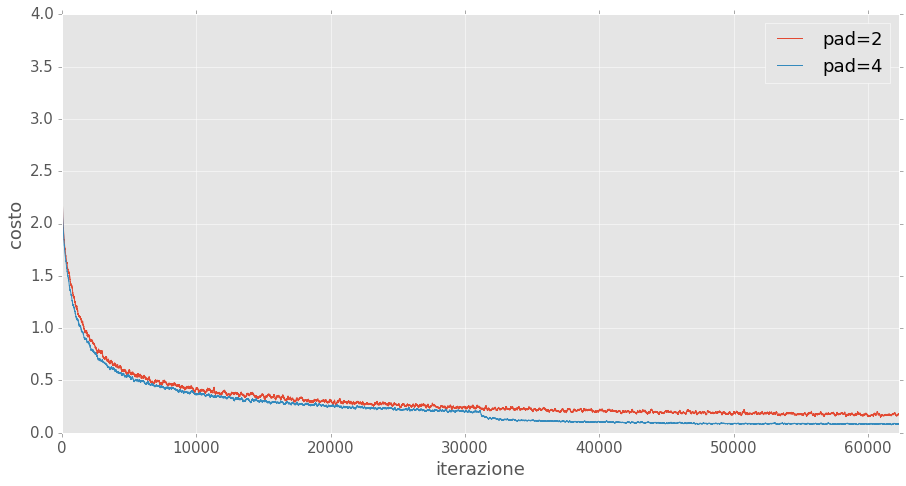

In [32]:
show_loss_comp((loss3, loss4), ['pad=2', 'pad=4'])


## Error Comparision


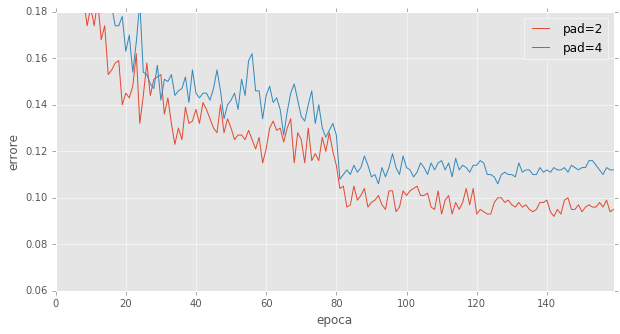

In [57]:
show_err_comp((val_err3, val_err4), ['pad=2', 'pad=4'], ylim=(0.06, 0.18))

---
# Exp.1 and 3 Comparision: nSize = 1/3, nPad = 2

In [98]:
loss1, tr_err1, val_err1 = results_for_exp(16)
loss2, tr_err2, val_err2 = results_for_exp(13)

## Loss

## Total training loss and train/ val errors


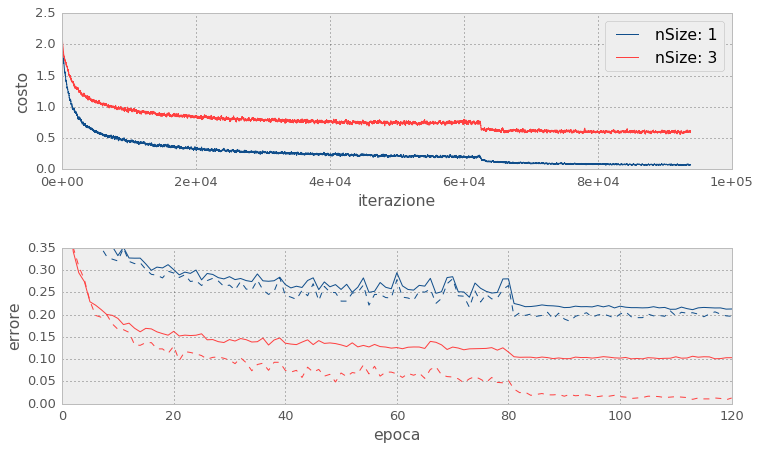

In [108]:
losses = (loss1[:93841], loss2[:93841])
losses_names = ('nSize: 1', 'nSize: 3')
errs = (val_err1[:121], tr_err1[:121], val_err2[:121], tr_err2[:121])
err_names = ('non res (val)', 'non res (train)',  'nSize: 1', 'nSize: 3')
show_all_comp(losses , losses_names, errs, err_names, ylim2=(0, 0.35))

##### Validation Error

## Error Comparision


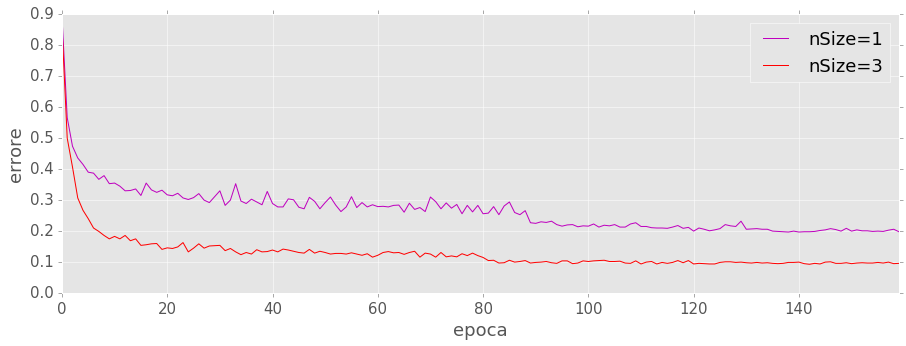

In [75]:
show_err_comp((val_err1, val_err2), ['nSize=1', 'nSize=3'])

## Error Comparision


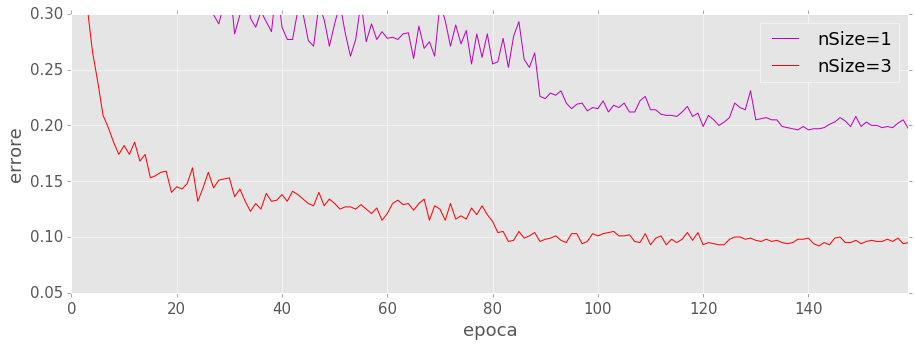

In [76]:
show_err_comp((val_err1, val_err2), ['nSize=1', 'nSize=3'], ylim=(0.05, 0.3))

## Total training loss and train/ val errors


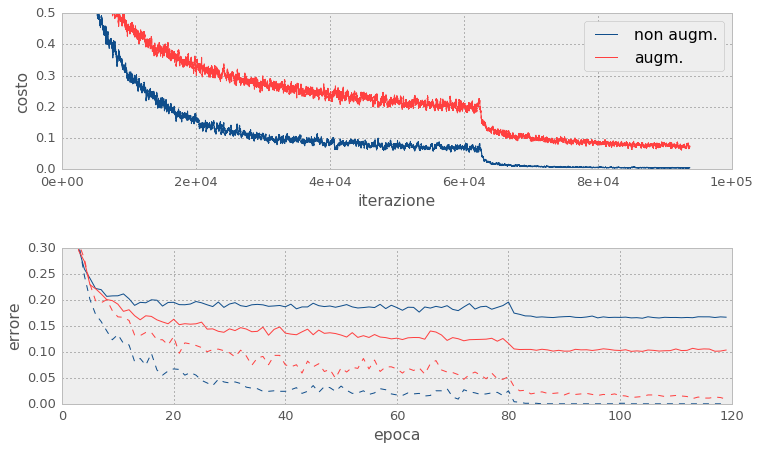

In [96]:
loss2, tr_err1, val_err1 = results_for_exp(14)
loss1, tr_err2, val_err2 = results_for_exp(13)


#show_loss_comp((loss1, loss2), ['non residual', 'residual'])

losses = (loss1[:len(loss2)], loss2)
losses_names = ('non augm.', 'augm.')
errs = (val_err1, tr_err1, val_err2[:120], tr_err2[:120])
err_names = ('1 (val)', '1 (train)',  '3 (val)', '3 (train)')
show_all_comp(losses , losses_names, errs, err_names, ylim1=(0,0.5), ylim2=(0,0.3))

#  Compute Predictions

For the experiments in this exercise it will be useful to have access to the predictions of the trained ResNEt on the CIFAR-10 validation set.

In [136]:
# train
exp = 15

#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))

#plt.imshow(grid.astype('uint8'))

res_net = ResNet(3)

solver = Solver(res_net)
solver.model.params = np.load('../Experiments/%d/model.npy' % exp).item()

predictions = solver.check_accuracy(data['X_test']*data['std'], data['y_test'], return_preds=True)

print 'Accuracy: %f' % np.mean(predictions ==  data['y_test'])


Accuracy Check: 100%|██████████| 10000/10000 [02:14<00:00, 71.12im/s]


Accuracy: 0.904100


## Total training loss and train/ val errors


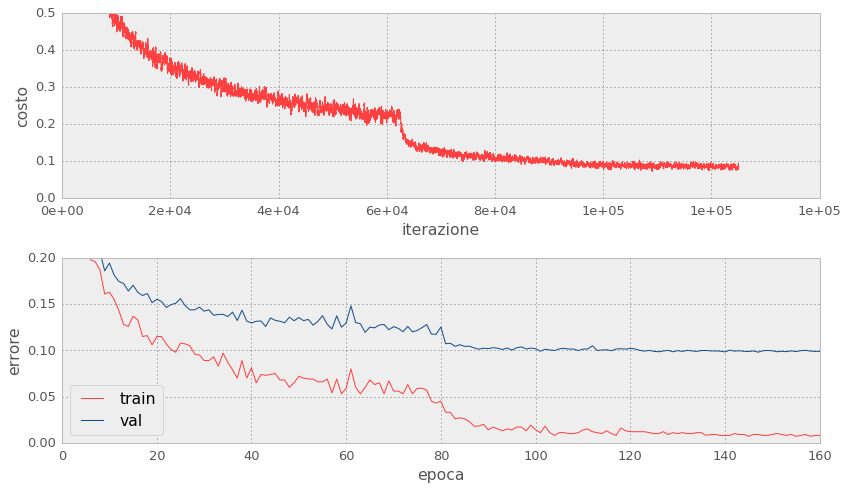

In [143]:
loss, tr_err, val_err = results_for_exp(15)
show_all(loss, tr_err, val_err, (0, 0.5), (0,0.2))

## Weights visualization


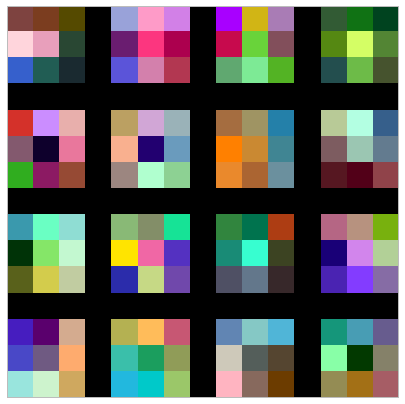

In [144]:
show_weights(15)

## Not Recognized Samples

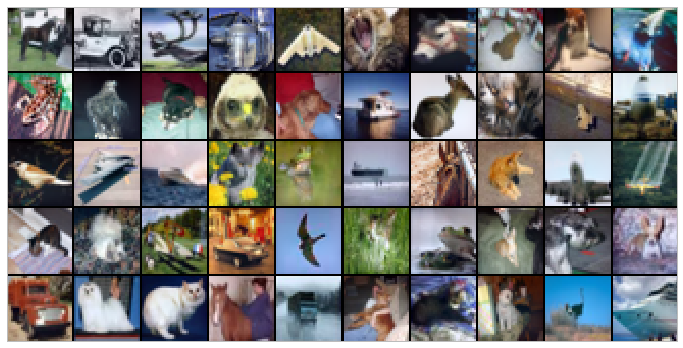

In [110]:
from nnet.utils.vis_utils import visualize_grid

wrong_pred = np.where(predictions != data['y_test'])


grid = visualize_grid(data['X_test'][wrong_pred].transpose(0, 2, 3, 1), grid_size=(10,5))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.set_xticks([])
ax.set_yticks([])


plt.imshow(grid.astype('uint8'))

#plt.savefig('mini_resnet_overfitting_images.png', dpi=100)


#grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
#plt.imshow(grid.astype('uint8'))


# Visualize Saliency Maps


Visualize Saliency Maps
In a recent paper [1], it was suggested that you can understand which part of an image is important for classification by visualizing the gradient of the correct class score with respect to the input image. This was covered in lecture on 2/2/2015 under the section "Visualize the data gradient". Recall that if a region of the image has a high data gradient, then this indicates that the output of the ConvNet is sensitive to perturbations in that region of the input image.

We will do something similar, instead visualizing the gradient of the data loss with respect to the input image; this gives similar results and is cleaner to implement using our codebase.

First, open the file cs231n/classifiers/convnet.py and modify the five_layer_net function to return the gradient of the loss with respect to the input when the compute_dX flag is true.

Once you have done so, complete the implementation in the following cell to allow you to visualize image-specific class saliency maps for images in the TinyImageNet-100-A validation set.

[1] K. Simonyan, A. Vedaldi, A. Zisserman , "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014

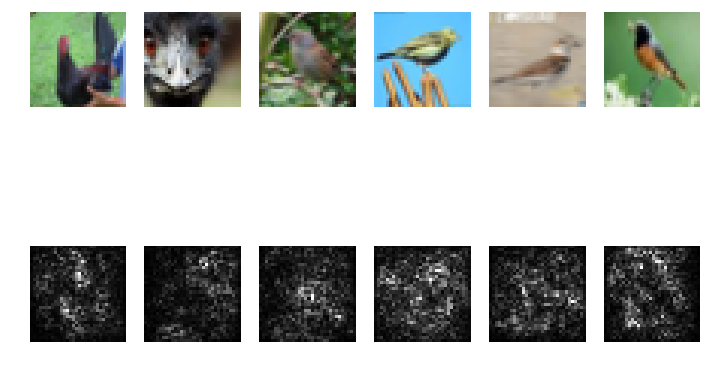

In [113]:
def show_image(img, rescale=False, add_mean=True):
    """
    Utility to show an image. In our ConvNets, images are 3D slices of 4D
    volumes; to visualize them we need to squeeze out the extra dimension,
    flip the axes so that channels are last, add the mean image, convert to
    uint8, and possibly rescale to be between 0 and 255. To make figures
    prettier we also need to suppress the axis labels after imshow.
    
    Input:
    - img: (1, C, H, W) or (C, H, W) or (1, H, W) or (H, W) giving
      pixel data for an image.
    - rescale: If true rescale the data to fit between 0 and 255
    - add_mean: If true add the training data mean image
    """
    img = img.copy()
    if add_mean:
        #
        img *= data['std']
        img += data['mean']
    img = img.squeeze()
    if img.ndim == 3:
        img = img.transpose(1, 2, 0)
    if rescale:
        low, high = np.min(img), np.max(img)
        img = 255.0 * (img - low) / (high - low)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

X_val = data['X_test']
y_val = data['y_test']
# The number of example images to show. You can change this.
num_examples = 6

# The label of the class to visualize. You can change this.
class_idx = 2 # 


example_idxs = None

# Choose several examples from the validation set whose correct label is
# class_idx and which are correctly classified by the pretrained ConvNet.
good_points = np.logical_and((predictions == y_val), (y_val == class_idx))
available_idxs, = np.nonzero(good_points)
example_idxs = available_idxs[0:num_examples]

# Array to store gradients of the loss with respect to your chosen example images.
dX = np.zeros((num_examples, 3, 32, 32))

# Compute loss gradients
dX = res_net.loss(X_val[example_idxs], y_val[example_idxs], compute_dX=True, return_probs=False)

# Plot the images and their saliency maps.
for i in xrange(num_examples):
    # Visualize the image
    plt.subplot(2, num_examples, i + 1)
    show_image(X_val[example_idxs[i]])
    #plt.title(class_names[y_val[example_idxs[i]]][0])
    
    # Saliency map for the ith example image.
    sal = np.zeros((32, 32))

    sal = np.max(np.abs(dX[i]), axis = 0)
    
    plt.subplot(2, num_examples, num_examples + i + 1)
    show_image(sal, rescale=True, add_mean=False)

# Fooling images

Two other papers [1, 2] discussed in lecture on 2/2 presented the idea of performing optimization over the input images to construct images that "fool" a trained ConvNet. This paper showed that given a trained ConvNet, an input image, and a desired label, that we can add a small amount of noise to the input image to force the ConvNet to classify it as having the desired label.

In this section we will reproduce some of these results.

Suppose that $L(x, y, m)$ is the data loss under model $m$, where we tell the network that the input $x$ should be classified as having label $y$. Given a starting image $x_0$, a desired label $y$, and a pretrained model $m$, we will create a fooling image $x_f$ by solving the following optimization problem:

$$x_f = \arg\min_x \left(L(x, y, m) + \frac\lambda2 \|x - x_0\|^2_2\right)$$

The term $\|x - x_0\|^2$ is $L_2$ regularization in image space which encourages the fooling image to look similar to the starting image, and the constant $\lambda$ is the strength of this regularization. We will use gradient descent to perform optimization under this model.

In the past, when using gradient descent we have stopped after a fixed number of iterations. Here we will use a different stopping criteria. Suppose that $p(x=y \mid m)$ is the probability that the input $x$ is assigned the label $y$ under the model $m$. We will specify a desired *confidence threshold* $t$ for the fooling image, and we will stop our optimization when we have $p(x_f=y\mid m) >= t$.

[1] Szegedy, Christian, et al. "Intriguing properties of neural networks." arXiv preprint, 2013.
<br>
[2] Nguyen, Anh, Jason Yosinski, and Jeff Clune. "Deep Neural Networks are Easily Fooled: High Confidence Predictions for Unrecognizable Images." arXiv preprint, 2014.

In [114]:
def make_fooling_image(img, y, model, reg=0.0, step_size=500, confidence=0.5):
    """
    Perform optimization in image space to create an image that is similar to img
    but is classified as y by model.
    
    Inputs:
    - img: Array of shape (1, C, H, W) containing (mean-subtracted) pixel data for
      the starting point for the fooling image.
    - y: The desired label; should be a single integer.
    - model: Dictionary mapping parameter names to weights; this is a pretrained
      five_layer_net model.
    - reg: Regularization strength (in image space) for the fooling image. This
      is the parameter lambda in the equation above.
    - step_size: The step size to use for gradient descent.
    - confidence: The desired confidence threshold for the fooling image.
    """
    fooling_img = img.copy()
    
    ################################################################################
    # Use gradient descent in image space to create a fooling image,               #
    # stopping when the predicted probability for the fooling image is greater     #
    # than the specified confidence threshold.                                     #
    ################################################################################
    while True:
        #import pdb; pdb.set_trace()
        dX = res_net.loss(fooling_img, np.array([y]), compute_dX=True)
        #_ = res_net.loss(fooling_img, np.array([y]))
        
        if res_net.loss(fooling_img, return_probs=True)[0, y] >= confidence:
            break
        fooling_img -= step_size*(dX+reg*(fooling_img-img)) #(dX)*step_size -reg*img
        
    return fooling_img

# Fooling images from correctly classified images
We will choose an image that is correctly classified by the pretrained network and create a fooling image that the network classifies as a goldfish.

You should experiment with different step sizes, regularizations, confidence thresholds, and target classes

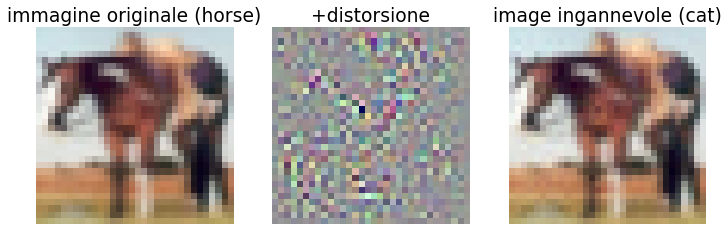

In [130]:
# Choose a random image that is correctly classified
idx = np.random.choice(np.nonzero(predictions == y_val)[0])
img = X_val[idx:idx+1]
class_idx = 3 # Goldfish
confidence = .5
fooling_img = make_fooling_image(img, class_idx, solver.model, step_size=2.5, reg=0.0, confidence=confidence)

# Check that the fooling image has probability above the threshold.
v = res_net.loss(fooling_img, return_probs=True)[0, class_idx]
assert v >= confidence,   'The ResNet is not fooled.'

# Show the original image
plt.subplot(1, 3, 1)
plt.title('immagine originale (%s)' % classes[y_val[idx]])
show_image(img)

# Show the difference between the original and fooling image
plt.subplot(1, 3, 2)
plt.title('+distorsione')
show_image(fooling_img - img, add_mean=False, rescale=True)

# Show the fooling image
plt.subplot(1, 3, 3)
plt.title('image ingannevole (%s)' % classes[class_idx])
show_image(fooling_img, add_mean=True,  rescale=True)
 

# Fooling image from random noise
Instead of starting from a correctly classified image, we can instead start our optimization from random noise. This will allow us to produce fooling images that do not look like anything to humans.

You should experiment with the scale of the initial random noise, the step size, the regularization, the confidence threshold, and the target class.

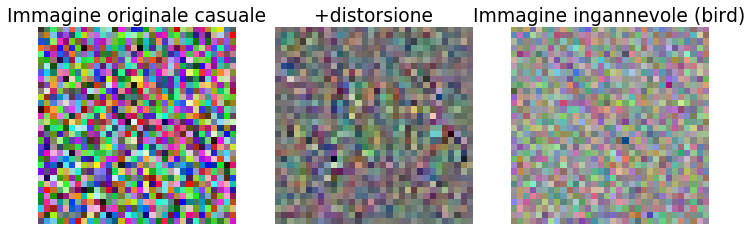

In [132]:
# Generate random noise to start
img =  20 * np.random.randn(1, 3, 32, 32)
class_idx = 2 # Goldfish
fooling_img = make_fooling_image(img, class_idx, res_net, step_size=50, reg=0.00, confidence=0.5)

# Check that the fooling image has probability above the threshold.
assert res_net.loss(fooling_img, return_probs=True)[0, class_idx] >= confidence, \
       'The ConvNet is not fooled.'

# Show the original image
plt.subplot(1, 3, 1)
plt.title('Immagine originale casuale')
show_image(img)

# Show the difference between the original and fooling image
plt.subplot(1, 3, 2)
plt.title('+distorsione')
show_image(fooling_img - img, add_mean=False, rescale=True)

# Show the fooling image
plt.subplot(1, 3, 3)
plt.title('Immagine ingannevole (bird)')
show_image(fooling_img, rescale=True)